In [4]:
from shortalyst.shors_algorithm import shors_algorithm
from shortalyst.shors_algorithm_no_optims import shors_algorithm as shors_no_optim

from pennylane_lightning.lightning_qubit import LightningQubit
import pennylane as qml
from catalyst import qjit, CompileOptions
import catalyst

from jax import random
from jax.core import ShapedArray
import jax.numpy as jnp
import random as rrandom
import time
import sympy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from math import log2
import matplotlib.ticker as mticker
from numpy.polynomial import Polynomial as Poly
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import FuncFormatter

In [5]:
qml.about()

Name: PennyLane
Version: 0.41.0.dev56
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /Users/jacksonfraser/.pyenv/versions/ugh/lib/python3.12/site-packages
Requires: appdirs, autograd, autoray, cachetools, diastatic-malt, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, tomlkit, typing_extensions
Required-by: amazon-braket-pennylane-plugin, PennyLane-Catalyst, PennyLane_Lightning, PennyLane_Lightning_Kokkos

Platform info:           macOS-14.0-arm64-arm-64bit
Python version:          3.12.1
Numpy version:           2.0.2
Scipy version:           1.15.2
Installed devices:
- braket.aws.ahs (amazon-braket-pennylane-plugin-1.31.2)
- braket.aws.qubit (amazon-braket-pennylane-plugin-1.31.2)
- braket.local.ahs (amazon-

In [6]:
import catalyst._version
catalyst._version.__version__

'0.12.0-dev4'

## Benchmarks for Catalyst Version

In [7]:
key = random.PRNGKey(123456789)
rrandom.seed(123456789)

bit_values = np.linspace(4, 32, 14, dtype=int)
N_values = [sympy.nextprime(2**(n_bits-1)) for n_bits in bit_values]

n_samples = 3

In [8]:
def mock_state_init(self):
    self.LightningStateVector = lambda *args, **kwargs: None

cat_data = np.zeros((len(bit_values), n_samples), dtype=float)
cat_data_no_optim = np.zeros((len(bit_values), n_samples), dtype=float)

for idx, n_bits in enumerate(bit_values):
    if n_bits % 4 == 0:
        print(f"measuring {n_bits} bits...")

    for k in range(n_samples):
        a = 2  # value not relevant for benchmark
        max_trials_per_a = 10
        # do not apply qjit decorator twice
        jit_function = qml.qjit(shors_algorithm.original_function, autograph=True, static_argnums=(2, 5, 6))
        jit_function_no_optim = qml.qjit(shors_no_optim.original_function, autograph=True, static_argnums=(2,))

        with catalyst.utils.patching.Patcher(
            (LightningQubit, "_set_lightning_classes", mock_state_init)
        ):
            start = time.time_ns()
            jit_function.jit_compile((int, int, n_bits, int, ShapedArray((2,), jnp.uint32), True, True))
            stop = time.time_ns()

            start_no_optim = time.time_ns()
            jit_function_no_optim.jit_compile((int, int, n_bits, int, ShapedArray((2,), jnp.uint32)))
            stop_no_optim = time.time_ns()

        result = (stop-start) / 1e9  # get time in s
        cat_data[idx][k] = result
        
        result_no_optim = (stop_no_optim-start_no_optim) / 1e9  # get time in s
        cat_data_no_optim[idx][k] = result_no_optim

cat_data[:3]

measuring 4 bits...
measuring 8 bits...
measuring 12 bits...
measuring 16 bits...
measuring 32 bits...


array([[10.737838,  2.25818 ,  2.396623],
       [ 2.173612,  2.233091,  2.239932],
       [ 2.204725,  2.247964,  2.445597]])

## Benchmarks for Pennylane Version

In [9]:
from shortalyst.utils import repeated_squaring
from shortalyst.modexpo import QFT, fourier_adder_phase_shift, controlled_ua_no_optims

def run_qpe(N, a, n_bits):
    est_wire = 0
    target_wires = list(range(1, n_bits + 1))
    aux_wires = list(range(n_bits + 1, 2 * n_bits + 3))

    measurements = []

    qml.PauliX(wires=target_wires[-1])
    QFT(wires=aux_wires[:-1])
    qml.Hadamard(wires=est_wire)

    QFT(wires=target_wires)
    qml.ctrl(fourier_adder_phase_shift, control=est_wire)(a - 1, target_wires)
    qml.adjoint(QFT)(wires=target_wires)

    qml.Hadamard(wires=est_wire)
    measurements.append(qml.measure(est_wire, reset=True))
    
    powers_cua = jnp.array([repeated_squaring(a, 2**p, N) for p in range(n_bits)])

    loop_bound = n_bits
    if jnp.min(powers_cua) == 1:
        loop_bound = jnp.argmin(powers_cua)

    for pow_a_idx in range(1, loop_bound):
        pow_cua = powers_cua[pow_a_idx]

        qml.Hadamard(wires=est_wire)

        controlled_ua_no_optims(
            N,
            pow_cua,
            est_wire,
            target_wires,
            aux_wires,
        )

        for meas_idx, meas in enumerate(measurements):
            qml.cond(meas, qml.PhaseShift)(
                -2 * jnp.pi / 2 ** (pow_a_idx + 2 - meas_idx), wires=est_wire
            )

        qml.Hadamard(wires=est_wire)
        measurements.append(qml.measure(est_wire, reset=True))

    qml.adjoint(QFT)(wires=aux_wires[:-1])

    return qml.sample(measurements)

In [10]:
from shortalyst.modexpo import fourier_adder_phase_shift, QFT, controlled_ua

def run_qpe_optim(N, a, n_bits):
    est_wire = 0
    target_wires = list(range(1, n_bits + 1))
    aux_wires = list(range(n_bits + 1, 2 * n_bits + 3))
    a_mask = jnp.zeros(n_bits, dtype=jnp.int64)
    a_mask = a_mask.at[0].set(1) + jnp.array(
        jnp.unpackbits(jnp.array([a]).view("uint8"), bitorder="little")[:n_bits]
    )
    a_inv_mask = a_mask

    measurements = []

    qml.PauliX(wires=target_wires[-1])

    QFT(wires=aux_wires[:-1])
    qml.Hadamard(wires=est_wire)

    QFT(wires=target_wires)
    qml.ctrl(fourier_adder_phase_shift, control=est_wire)(a - 1, target_wires)
    qml.adjoint(QFT)(wires=target_wires)


    qml.Hadamard(wires=est_wire)
    measurements.append(qml.measure(est_wire, reset=True))

    powers_cua = jnp.array([repeated_squaring(a, 2**p, N) for p in range(n_bits)])
    max_pow_a_target_reg = jnp.array([a], dtype=jnp.int32)

    loop_bound = n_bits
    if jnp.min(powers_cua) == 1:
        loop_bound = jnp.argmin(powers_cua)

    for pow_a_idx in range(1, loop_bound):
        pow_cua = powers_cua[pow_a_idx]

        if not jnp.all(a_inv_mask):
            for power in range(2**pow_a_idx, 2 ** (pow_a_idx + 1)):
                next_pow_a = jnp.array([repeated_squaring(a, power, N)])
                next_max_pow_a_targ_reg = jnp.maximum(next_pow_a, max_pow_a_target_reg)
                a_inv_mask = a_inv_mask + jnp.array(
                    jnp.unpackbits(next_pow_a.view("uint8"), bitorder="little")[:n_bits]
                )

        qml.Hadamard(wires=est_wire)

        controlled_ua(
            N,
            pow_cua,
            est_wire,
            target_wires,
            aux_wires,
            a_mask,
            a_inv_mask,
            max_pow_a_target_reg[0],
        )


        a_mask = a_mask + a_inv_mask
        a_inv_mask = jnp.zeros_like(a_inv_mask)

        max_pow_a_target_reg = next_max_pow_a_targ_reg

        for meas_idx, meas in enumerate(measurements):
            qml.cond(meas, qml.PhaseShift)(
                -2 * jnp.pi / 2 ** (pow_a_idx + 2 - meas_idx), wires=est_wire
            )

        qml.Hadamard(wires=est_wire)
        measurements.append(qml.measure(est_wire, reset=True))

    qml.adjoint(QFT)(wires=aux_wires[:-1])

    return qml.sample(measurements)

In [11]:
n_datapoints = 7

pl_data = np.zeros((n_datapoints, n_samples), dtype=float)
pl_data_optims = np.zeros((n_datapoints, n_samples), dtype=float)

for idx, (n_bits, N) in enumerate(zip(bit_values[:n_datapoints], N_values[:n_datapoints])):
    print(f"measuring {n_bits} bits...")

    a = 2  # value not relevant for benchmark
    n_wires = 2*n_bits + 3

    dev = qml.device("lightning.qubit", wires=n_wires, shots=1)

    for k in range(n_samples):
        qnode_function = qml.qnode(dev, interface="jax")(run_qpe)
        qnode_function_optim = qml.qnode(dev, interface="jax")(run_qpe_optim)
        # We want to measure all the QNode & device pre-processing, without including execution.
        with catalyst.utils.patching.Patcher((qml, "execute", lambda *args, **kwargs: [None])):
            start = time.time_ns()
            qnode_function(N, a, n_bits)
            stop = time.time_ns()

            start_optims = time.time_ns()
            qnode_function_optim(N, a, n_bits)
            stop_optims = time.time_ns()

        result = (stop-start) / 1e9  # get time in s
        pl_data[idx][k] = result

        result_optims = (stop_optims-start_optims) / 1e9  # get time in s
        pl_data_optims[idx][k] = result_optims

pl_data[:3]

measuring 4 bits...
measuring 6 bits...
measuring 8 bits...
measuring 10 bits...
measuring 12 bits...
measuring 14 bits...
measuring 16 bits...


array([[0.524577, 0.151665, 0.15227 ],
       [0.801788, 0.649614, 0.522206],
       [1.599259, 1.77404 , 1.735944]])

In [ ]:
# np.save("./data/pennylane_data_not_optimized.npy", pl_data)
# np.save("./data/pennylane_data_optimized.npy", pl_data_optims)
# np.save("./data/catalyst_data_optimized", cat_data)
# np.save("./data/catalyst_data_not_optimized", cat_data_no_optim)

## Plotting

In [ ]:
# cat_data = np.load('data/cat_data_optimized.npy')
# cat_data_no_optim = np.load('data/cat_data_no_optim.npy')
# pl_data = np.load('data/pl_data.npy')
# pl_data_optims = np.load("./data/pl_data_optims.npy")

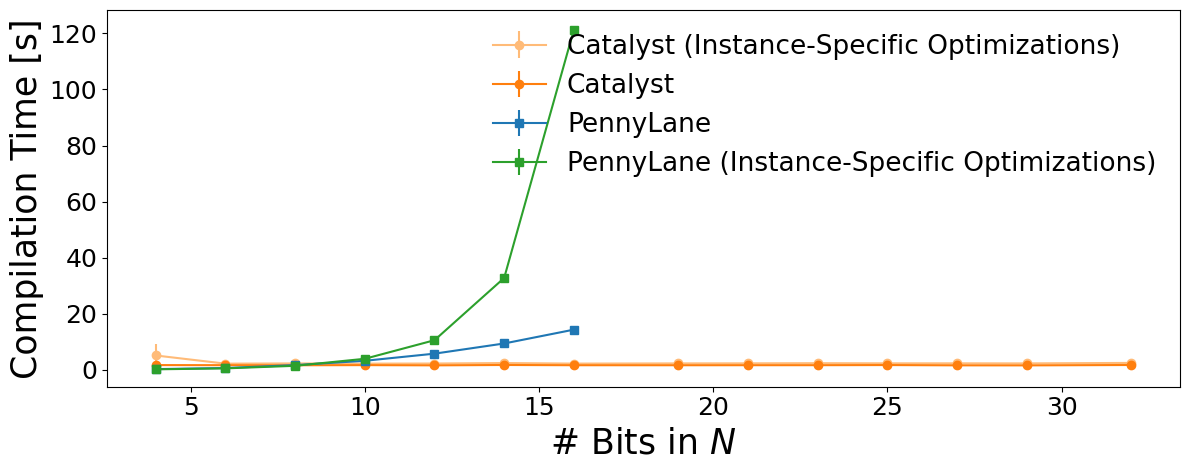

In [12]:
n_datapoints = 7

cat_x_data = bit_values

cat_y_data = np.mean(cat_data, axis=1)
cat_y_data_nooptim = np.mean(cat_data_no_optim, axis=1)

cat_y_err = np.std(cat_data, axis=1)
cat_y_err_nooptim = np.std(cat_data_no_optim, axis=1)

pl_x_data = bit_values[:n_datapoints]

pl_y_data = np.mean(pl_data, axis=1)
pl_y_err = np.std(pl_data, axis=1)

pl_y_data_optims = np.mean(pl_data_optims, axis=1)
pl_y_err_optims = np.std(pl_data_optims, axis=1)

plt.figure(figsize=(12, 4.8))
yellow = plt.cm.tab20(2)
blue = plt.cm.tab20(1)
c = plt.cm.tab20(3)
c1 = plt.cm.tab20(4)

plt.errorbar(cat_x_data, cat_y_data, yerr=cat_y_err, marker="o", label="Catalyst (Instance-Specific Optimizations)", c=c, zorder=2)
plt.errorbar(cat_x_data, cat_y_data_nooptim, yerr=cat_y_err_nooptim, marker="o", label="Catalyst", color='#ff7f0e', zorder=2)
plt.errorbar(pl_x_data, pl_y_data, yerr=pl_y_err, marker="s", label="PennyLane", color='#1f77b4', ls="-", zorder=2)
plt.errorbar(pl_x_data, pl_y_data_optims, yerr=pl_y_err_optims, marker="s", label="PennyLane (Instance-Specific Optimizations)", c=c1, ls="-", zorder=2)


plt.xlabel("# Bits in $N$", fontsize=25)
plt.ylabel("Compilation Time [s]", fontsize=25)
plt.legend(loc="upper right", fontsize=19, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
# plt.savefig("compilation_timing_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

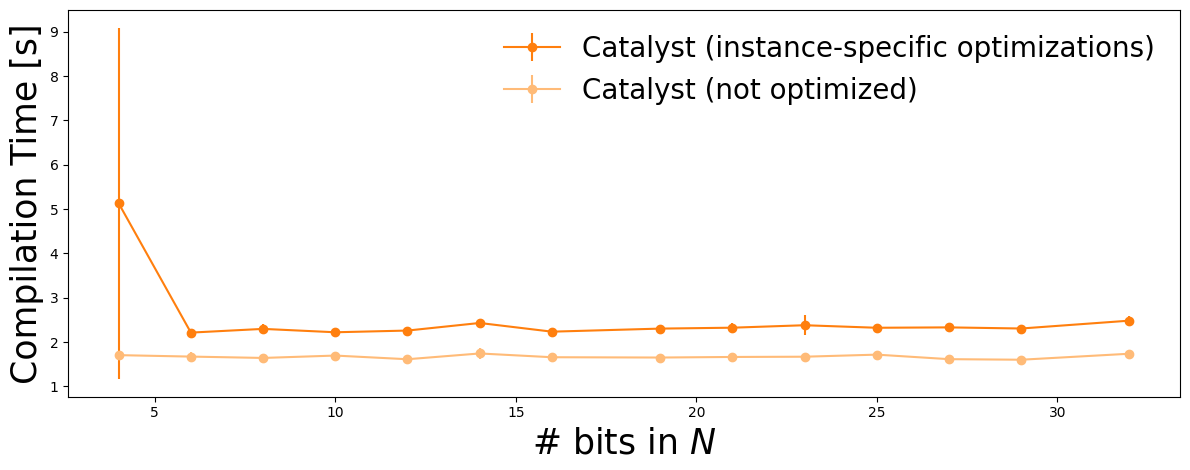

In [13]:
plt.figure(figsize=(12, 4.8))
yellow = plt.cm.tab20(2)
c = plt.cm.tab20(3)

plt.errorbar(cat_x_data, cat_y_data, yerr=cat_y_err, marker="o", label="Catalyst (instance-specific optimizations)", c=yellow, zorder=2)
plt.errorbar(cat_x_data, cat_y_data_nooptim, yerr=cat_y_err_nooptim, marker="o", label="Catalyst (not optimized)", c=c, zorder=2)

plt.xlabel("# bits in $N$", fontsize=25)
plt.ylabel("Compilation Time [s]", fontsize=25)
plt.legend(loc="upper right", fontsize=20, frameon=False)

plt.tight_layout()
plt.show()

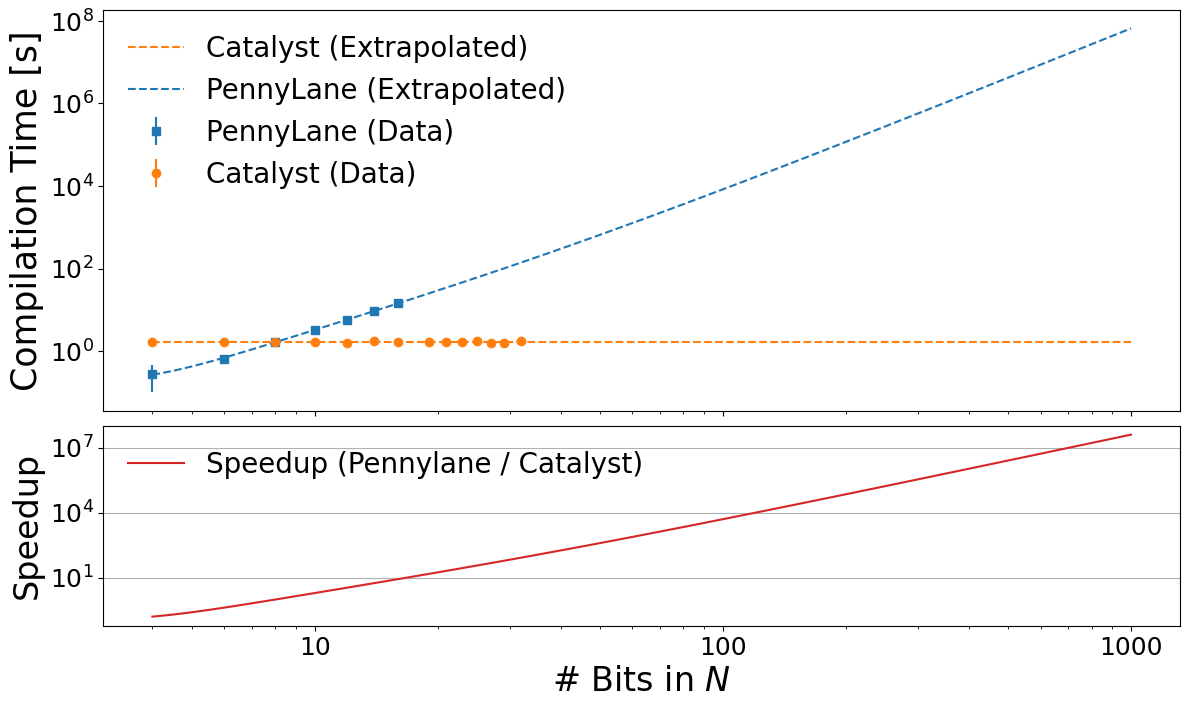

In [14]:
def log_formatter(x, pos):
    return r"$10^{{{}}}$".format(int(np.log10(x))) if x != 0 else "0"


cat_fit = Poly.fit(cat_x_data, cat_y_data, deg=0)
cat_fit_no_optim = Poly.fit(cat_x_data, cat_y_data_nooptim, deg=0)
pl_fit = Poly.fit(pl_x_data, pl_y_data, deg=4)

extrap_x_data = np.geomspace(4, 1000, 100, endpoint=True)
extrap_cat_y_data = cat_fit(extrap_x_data)
extrap_cat_no_optim_y_data = cat_fit_no_optim(extrap_x_data)
extrap_pl_y_data = pl_fit(extrap_x_data)


fig = plt.figure(figsize=(12, 7.2))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
yellow = plt.cm.tab20(2)
blue = plt.cm.tab20(1)
cl = plt.cm.tab20(3)
cy = plt.cm.tab20(4)


ax1.errorbar(pl_x_data, pl_y_data, yerr=pl_y_err, marker="s", label="PennyLane (Data)", color='#1f77b4', ls="", zorder=2)
ax1.errorbar(cat_x_data, cat_y_data_nooptim, yerr=cat_y_err_nooptim, marker="o", label="Catalyst (Data)", color='#ff7f0e', ls="", zorder=2)


ax1.plot(extrap_x_data, extrap_cat_no_optim_y_data, marker="", label="Catalyst (Extrapolated)", color='#ff7f0e', ls="--", zorder=2)
ax1.plot(extrap_x_data, extrap_pl_y_data, marker="", label="PennyLane (Extrapolated)", color='#1f77b4', ls="--", zorder=2)


ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("Compilation Time [s]", fontsize=25)
ax1.legend(loc="upper left", fontsize=20, frameon=False)
ax1.tick_params(labelbottom=False, labelleft=True)
ax1.tick_params(axis='both', which='major', labelsize=18)

# ax2.plot(extrap_x_data, extrap_pl_optim_y_data/extrap_cat_y_data, c=yellow, marker="", label="speedup with instance-specific optimizations")
ax2.plot(extrap_x_data, extrap_pl_y_data/extrap_cat_no_optim_y_data, color='#d62728', marker="", label='Speedup (Pennylane / Catalyst)')

ax2.set_xlabel("# Bits in $N$", fontsize=24)
ax2.set_ylabel("Speedup", fontsize=24)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.xaxis.set_major_formatter(mticker.ScalarFormatter())

ax2.set_yscale("log")
ax2.yaxis.set_major_formatter(FuncFormatter(log_formatter))

ax2.grid(axis="y", zorder=0)
ax2.legend(loc="upper left", fontsize=20, frameon=False)
ax2.tick_params(axis='both', which='major', labelsize=18)


plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
# plt.savefig("extrapolated_comp_timing.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
bit_sizes = [2048, 4096, 8192]

cat_predictions = cat_fit(bit_sizes)
pl_predictions = pl_fit(bit_sizes)

for i, bits in enumerate(bit_sizes):
    speedup = pl_predictions[i] / cat_predictions[i]
    print(f"Bits: {bits}")
    print(f"  Catalyst:   {cat_predictions[i]:.2f} seconds")
    print(f"  PennyLane: {pl_predictions[i]:.2f} seconds")
    print(f"  Speedup:    {speedup:.2f}x")
    print()

Bits: 2048
  Catalyst:   2.52 seconds
  PennyLane: 1139427993.73 seconds
  Speedup:    452342775.28x

Bits: 4096
  Catalyst:   2.52 seconds
  PennyLane: 18110814969.61 seconds
  Speedup:    7189832399.27x

Bits: 8192
  Catalyst:   2.52 seconds
  PennyLane: 288816665875.16 seconds
  Speedup:    114657646563.36x



In [16]:
df = pd.read_csv("./data/shor_stats_11.csv")
df.head()

,N,a,version,num_qubits,num_gates,gate_types
0,35,2,1,15,6939,"{'CNOT': 146, 'PhaseShift': 306, 'C_C_PhaseShi..."
1,35,2,0,15,9366,"{'CNOT': 180, 'PhaseShift': 425, 'C_C_PhaseShi..."
2,35,9,1,15,6051,"{'CNOT': 134, 'PhaseShift': 264, 'C_C_PhaseShi..."
3,35,9,0,15,9384,"{'CNOT': 180, 'PhaseShift': 425, 'C_C_PhaseShi..."
4,35,3,1,15,6352,"{'CNOT': 138, 'PhaseShift': 278, 'C_C_PhaseShi..."


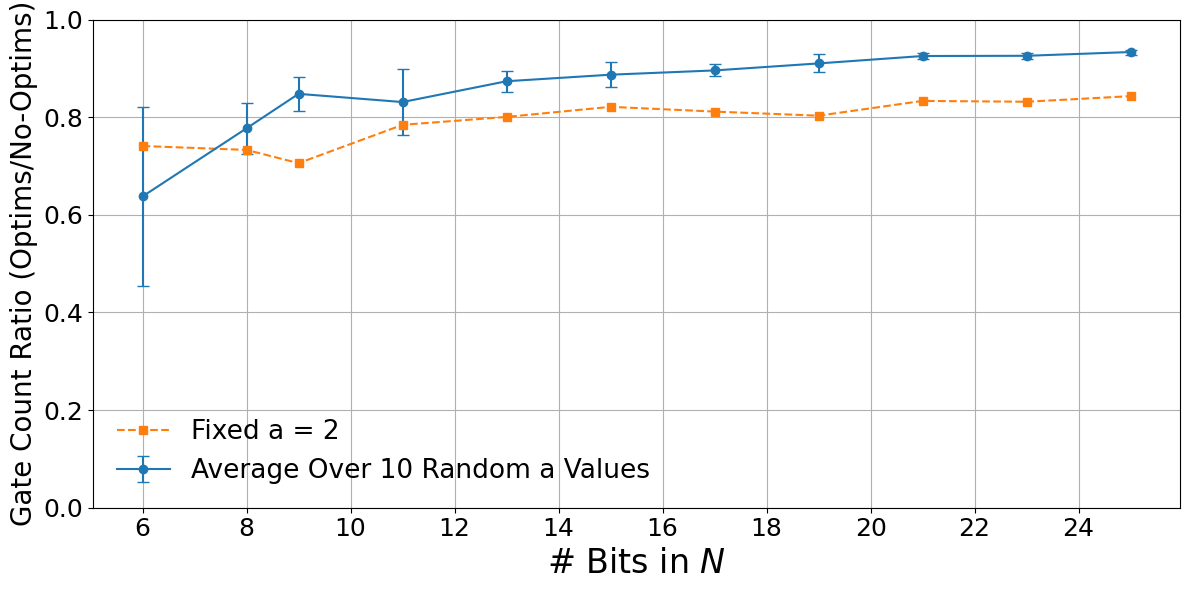

In [17]:
df["bit_width"] = df["N"].apply(lambda n: int(log2(n)) + 1)

# Pivot data
pivot = df.pivot_table(
    index=["N", "bit_width", "a"],
    columns="version",
    values="num_gates"
).reset_index()

pivot = pivot.dropna(subset=[1, 0])
pivot["gate_ratio"] = pivot[1] / pivot[0]

no_a2 = pivot[pivot["a"] != 2]
stats = no_a2.groupby("bit_width")["gate_ratio"].agg(['mean', 'std']).reset_index()

fixed_a = pivot[pivot["a"] == 2]
fixed_ratio = fixed_a[["bit_width", "gate_ratio"]].sort_values("bit_width")

plt.figure(figsize=(12, 6))

plt.errorbar(stats["bit_width"], stats["mean"], yerr=stats["std"], 
             fmt='o-', label="Average Over 10 Random a Values", capsize=4)

plt.plot(fixed_ratio["bit_width"], fixed_ratio["gate_ratio"], marker="s", linestyle="--", label="Fixed a = 2")

plt.xlabel("# Bits in $N$", fontsize=24)
plt.ylabel("Gate Count Ratio (Optims/No-Optims)", fontsize=20)
plt.ylim([0.0, 1.0])
plt.grid(True)
plt.legend(fontsize=19, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xticks(np.arange(stats["bit_width"].min(), stats["bit_width"].max() + 1, 2))
plt.tight_layout()
# plt.savefig("gate_count_ratios.pdf", format="pdf", bbox_inches="tight")
plt.show()
